In [1]:
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from category_encoders import TargetEncoder

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

/var/folders/36/4qq8yw917gx9npbp0w2hv6t80000gn/T/ipykernel_4216/899843628.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Loading

In [2]:
df = pd.read_csv("../cars.csv", sep=";", encoding="utf-16")

In [3]:
df.head()

,brand,currency,description,model,price,url,year,Город,Коробка передач,Кузов,"Объем двигателя, л",Привод,Растаможен,Руль,Цвет,Пробег,Наличие,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,4.8 (бензин),полный привод,Да,слева,черный,170 км,NaN,NaN
2,Mercedes-Benz,₸,"лонг, состояние нового авто немец газ-бензин п...",S 350,7770000,https://kolesa.kz/a/show/1063798,2006,Алматы,типтроник,седан,3.5 (бензин),NaN,Да,слева,черный,60 000 км,NaN,NaN
3,Mitsubishi,₸,"литые диски, тонировка, люк , хрустальная опт...",Outlander,3200000,https://kolesa.kz/a/show/10695701,2003,Семей,типтроник,кроссовер,2.4 (бензин),полный привод,Да,слева,серебристый металлик,120 000 км,NaN,NaN
4,Ретро-автомобили,₸,"налог уплачен, техосмотр пройден, вложений не ...","ГАЗ 21 ""Волга""",3900000,https://kolesa.kz/a/show/10852142,1970,Алматы,механика,седан,2.4 (бензин),задний привод,Да,слева,черный,1 200 км,NaN,NaN


In [4]:
df.shape

(108536, 18)

# Data Cleaning

Приведем названия колонок к одному формату

In [5]:
df.rename(columns={"Город": "city", 
                   "Коробка передач": "transmission", 
                   "Кузов": "body", 
                   "Объем двигателя, л": "engine",
                   "Привод": "drive",
                   "Растаможен": "cleared",
                   "Руль": "wheel",
                   "Цвет": "color",
                   "Пробег": "mileage",
                   "Наличие": "stock"}, inplace=True)


In [6]:
df.head(2)

,brand,currency,description,model,price,url,year,city,transmission,body,engine,drive,cleared,wheel,color,mileage,stock,VIN
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,5.5 (бензин),полный привод,Да,слева,черный металлик,NaN,NaN,NaN
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,4.8 (бензин),полный привод,Да,слева,черный,170 км,NaN,NaN


Распарсим некоторые колонки: `engine`, `mileage`

In [7]:
df["liters"] = df.engine.apply(lambda x: x.split()[0] if x is not np.NaN else np.NaN)
df["fuel"] = df.engine.apply(lambda x: x.split()[1][1:-1] if x is not np.NaN else np.NaN)
df.drop("engine", axis=1, inplace=True)

pattern = r"\d+"
df["mileage"] = df.mileage.apply(lambda x: int("".join(re.findall(pattern, x))) if x is not np.NaN else np.NaN)

In [8]:
df.head(2)

,brand,currency,description,model,price,url,year,city,transmission,body,drive,cleared,wheel,color,mileage,stock,VIN,liters,fuel
0,Mercedes-Benz,₸,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,https://kolesa.kz/a/show/10235750,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,NaN,NaN,5.5,бензин
1,BMW,₸,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,https://kolesa.kz/a/show/10269314,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170.0,NaN,NaN,4.8,бензин


In [9]:
print("Количество пропусков в данных по колонкам (проценты):")
round(df.isnull().sum() / len(df) * 100, 1).astype("str") + " %"

Количество пропусков в данных по колонкам (проценты):


brand            0.0 %
currency         0.0 %
description      4.8 %
model            0.0 %
price            0.0 %
url              0.0 %
year             0.0 %
city             0.0 %
transmission     0.0 %
body             0.0 %
drive           12.6 %
cleared          0.0 %
wheel            0.0 %
color            9.8 %
mileage         40.3 %
stock           96.2 %
VIN             95.7 %
liters           0.0 %
fuel             0.0 %
dtype: object

In [10]:
df[~df.VIN.isna()].head(2)

,brand,currency,description,model,price,url,year,city,transmission,body,drive,cleared,wheel,color,mileage,stock,VIN,liters,fuel
42,Toyota,₸,"литые диски, тонировка , противотуманки, обог...",Avalon,1300000,https://kolesa.kz/a/show/15156794,1997,Актау,автомат,седан,передний привод,Да,справа,белый металлик,352000.0,NaN,MCX10003*20****..,3,газ-бензин
104,Mercedes-Benz,₸,"люк, литые диски, обвес, тонировка, спойлер , ...",GL 550,10700000,https://kolesa.kz/a/show/19347548,2009,Алматы,автомат,внедорожник,полный привод,Да,слева,белый,77107.0,NaN,4JGBF86E*9A****38,5.5,бензин


In [11]:
df.stock.unique()

array([nan, 'На заказ'], dtype=object)

Колонки `stock` и `VIN` имеют 96% и 95% пропусков соответственно, а также не содержат полезных данных для обучения, поэтому их стоит удалить

In [12]:
df = df.drop(["stock", "VIN"], axis=1)

In [13]:
df.currency.unique()

array(['₸'], dtype=object)

Также удалим сразу колонку `currency`, поскольку там только одно уникальное значение

Удалим сразу еще `url`, поскольку эта колонка нам точно не понадобится в обучении

In [14]:
df = df.drop(["currency", "url"], axis=1)

# EDA

## Target

In [15]:
df.head(2)

,brand,description,model,price,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,5.5,бензин
1,BMW,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170.0,4.8,бензин


Наш таргет - `price`, поэтому посмотрим его распределение

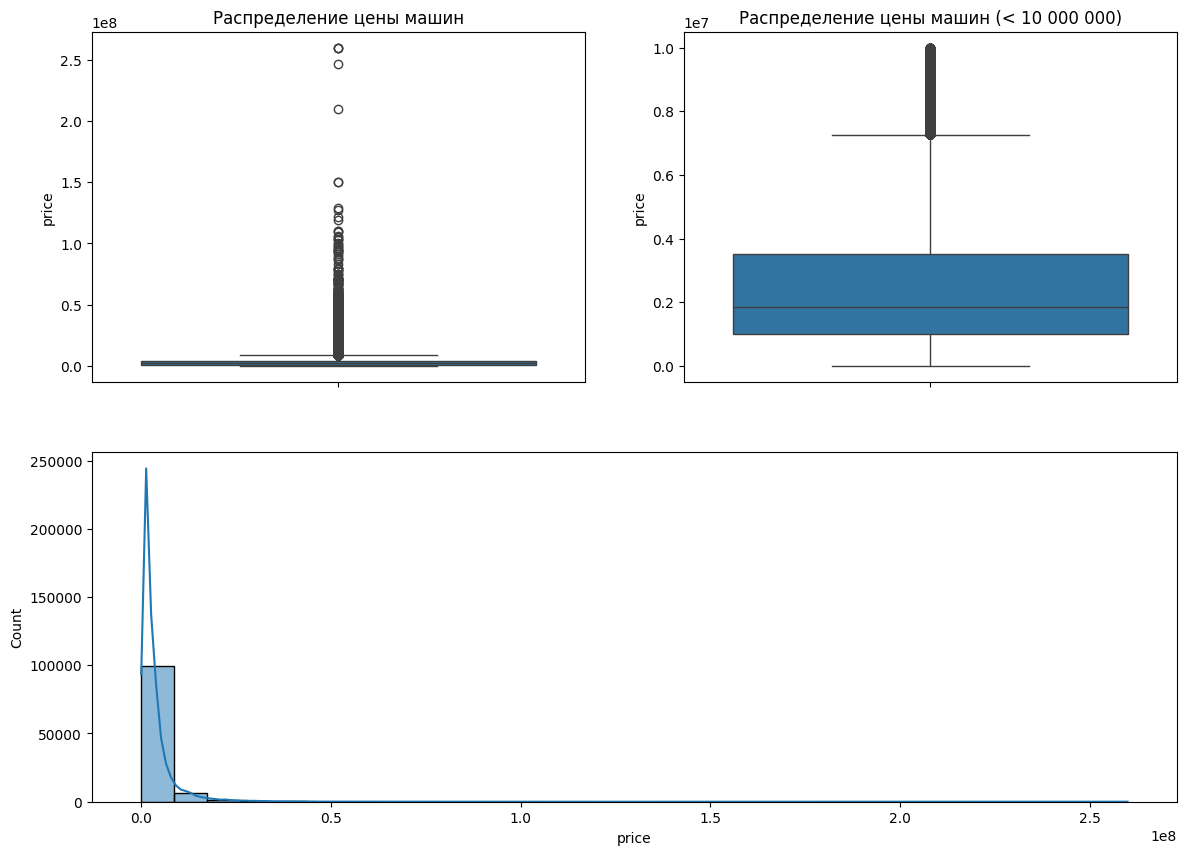

In [16]:
fig = plt.figure(figsize=(14, 10))

ax_1 = plt.subplot(2, 2, 1)
sns.boxplot(df.price)

plt.title("Распределение цены машин")

ax_2 = plt.subplot(2, 2, 2)
sns.boxplot(df[df.price < 10_000_000].price)

plt.title("Распределение цены машин (< 10 000 000)")

ax_2 = plt.subplot(2, 1, 2)
sns.histplot(df['price'], kde=True, bins=30)

plt.show()

Кажется, что здесь есть большое количетсво выбросов, по цене автомобиля, что может плохо сказаться на работе модели

In [17]:
IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
highest_price = df.price.quantile(0.75) + IQR * 3
print(f"Количество машин, дороже {int(highest_price)} (75-квантиль + 3 межквар. интервала): \t{df[df.price > highest_price].shape[0]}")

Количество машин, дороже 13000000 (75-квантиль + 3 межквар. интервала): 	4517


Предлагаю считать выбросами все, что лежит выше (75-квантиля + 3 межквартильных интервала)

Если нам так же важно предсказывать более дорогие авто, то я бы завел отдельную модель для этого.

In [18]:
df = df[df.price <= highest_price]

## Year

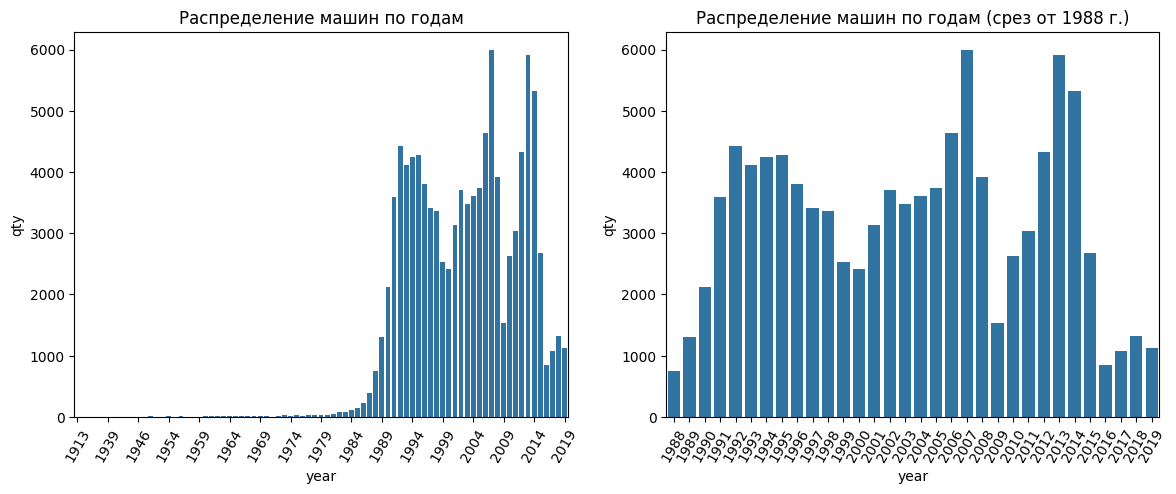

In [19]:
year_groupby = df.groupby("year", as_index=False).model \
    .count() \
    .rename(columns={"model": "qty"})

fig = plt.figure(figsize=(14, 5))

ax_1 = plt.subplot(1, 2, 1)
sns.barplot(data=year_groupby, x="year", y="qty")

plt.title("Распределение машин по годам")
plt.xticks(ticks=[i for i in range(len(year_groupby))][::5], rotation=60)


ax_2 = plt.subplot(1, 2, 2)
sns.barplot(data=year_groupby[year_groupby.year >=1988], x="year", y="qty")

plt.title("Распределение машин по годам (срез от 1988 г.)")
plt.xticks(rotation=60)

plt.show()

Данные предоставленны о машинах до 2019 года. Наиболее часто встречаются автомобили 2013 года производства

In [20]:
print(f"Машин < 1988 года: \t{df[df.year < 1988].shape[0]}")

Машин < 1988 года: 	1583


Обрежу датасет по 1988 год, поскольку до 1988 мало данных + это в основном ретро-автомобили, либо ошибки в данных

Нам важнее предсказывать точно более свежие машины, а если важно уметь предсказывать ретро-автомобили, то я бы завел для этого отдельную модель

In [21]:
df = df[df.year >= 1988]

## Brand

Кажется, что цена машины зависит от ее марки

In [22]:
df.head(1)

,brand,description,model,price,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,5.5,бензин


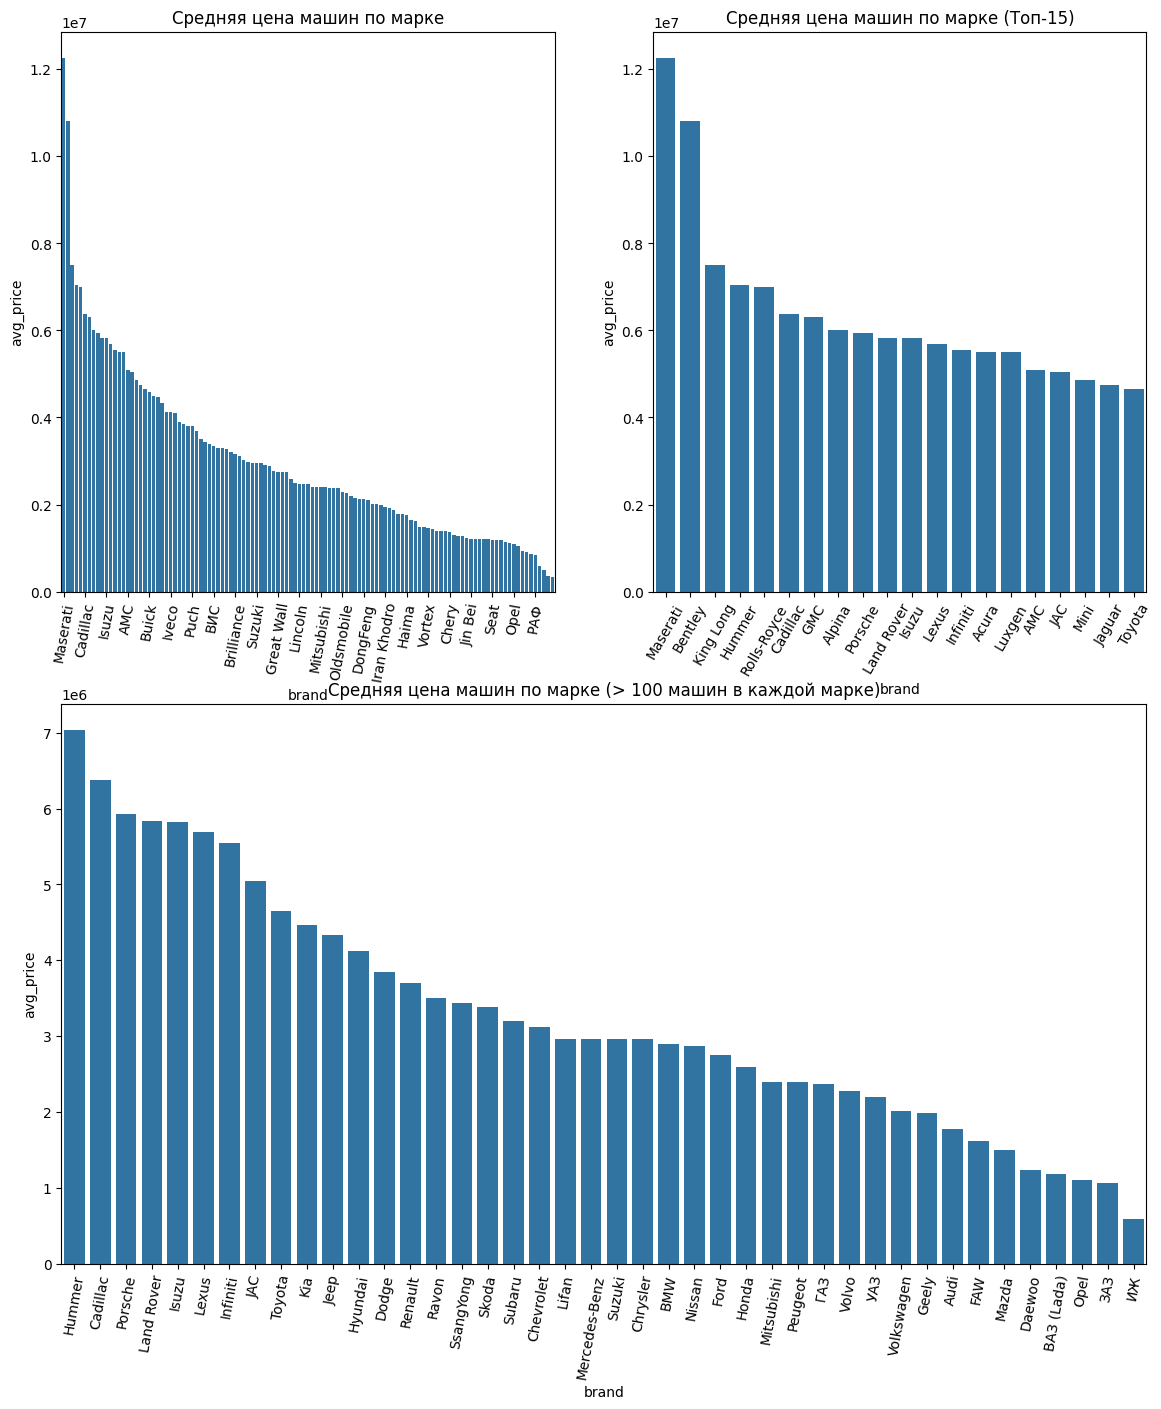

In [23]:
brand_price_groupby = df.groupby("brand", as_index=False) \
    .agg({"price": "mean", "year": "count"}) \
    .rename(columns={"price": "avg_price", "year": "qty"}) \
    .sort_values("avg_price", ascending=False)
order = brand_price_groupby.brand.tolist()

fig = plt.figure(figsize=(14, 16))

ax_1 = plt.subplot(2, 2, 1)
sns.barplot(data=brand_price_groupby, x="brand", y="avg_price")

plt.title("Средняя цена машин по марке")
plt.xticks(ticks=[i for i in range(len(brand_price_groupby))][::5], rotation=80)


ax_2 = plt.subplot(2, 2, 2)
sns.barplot(data=brand_price_groupby[:20], x="brand", y="avg_price")

plt.title("Средняя цена машин по марке (Топ-15)")
plt.xticks(rotation=60)


ax_3 = plt.subplot(2, 1, 2)

sns.barplot(data=brand_price_groupby[brand_price_groupby.qty > 100], x="brand", y="avg_price")

plt.title("Средняя цена машин по марке (> 100 машин в каждой марке)")
plt.xticks(rotation=80)

plt.show()

В самом деле марка автомобиля влияет на цену автомобиля, поэтому это хороший признак, который мы оставим

In [24]:
df.brand.nunique()

115

## Color

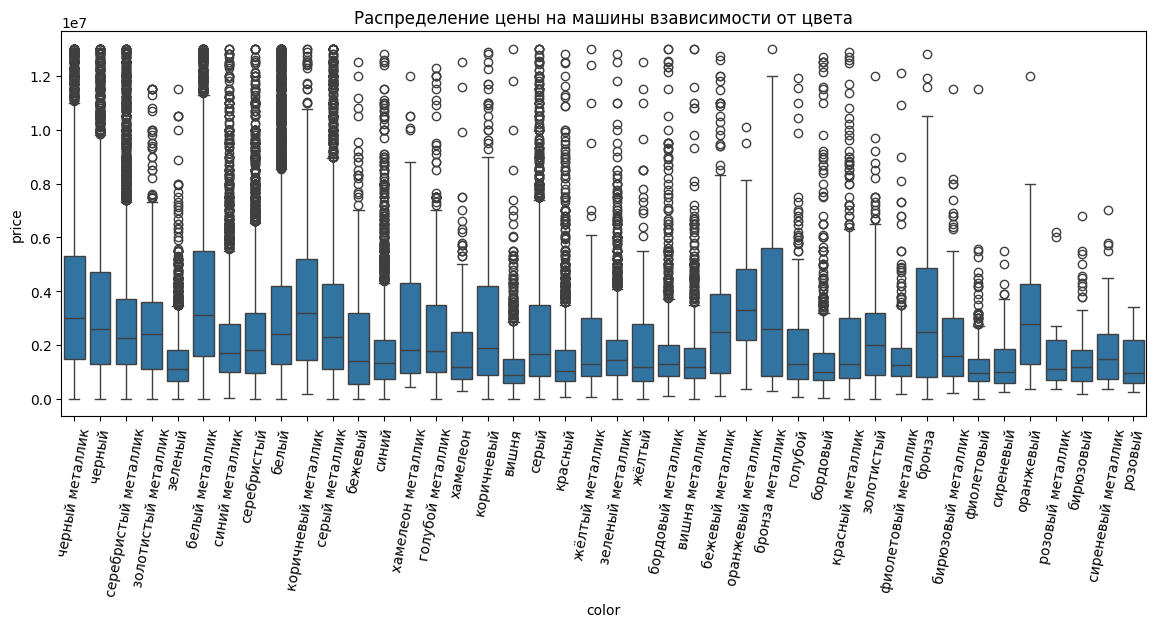

In [25]:
fig = plt.figure(figsize=(14, 5))

sns.boxplot(data=df, x="color", y="price")

plt.title("Распределение цены на машины взависимости от цвета")
plt.xticks(rotation=80)

plt.show()

Видно что взависимости от цвета авто, разное распределение таргета, поэтому фича `color` должна быть довольно полезной

# Train Test Split

In [26]:
X = df.drop("price", axis=1)
y = df.price

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

На всякий случай проверим распределение таргета в трейне и тесте

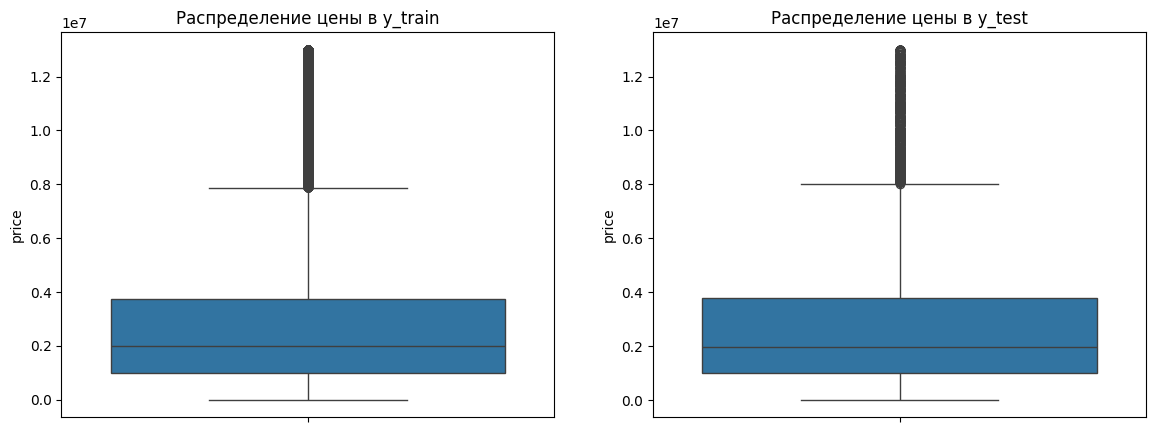

In [28]:
fig = plt.figure(figsize=(14, 5))

ax_1 = plt.subplot(1, 2, 1)
sns.boxplot(y_train)

plt.title("Распределение цены в y_train")

ax_1 = plt.subplot(1, 2, 2)
sns.boxplot(y_test)

plt.title("Распределение цены в y_test")

plt.show()

# Missing data

Поработаем с пропусками в данных

In [29]:
print("Количество пропусков в данных по колонкам (проценты):")

print(round(df.isnull().sum() / len(df) * 100, 1).astype("str") + " %")

Количество пропусков в данных по колонкам (проценты):
brand            0.0 %
description      4.9 %
model            0.0 %
price            0.0 %
year             0.0 %
city             0.0 %
transmission     0.0 %
body             0.0 %
drive           12.4 %
cleared          0.0 %
wheel            0.0 %
color            9.5 %
mileage         40.0 %
liters           0.0 %
fuel             0.0 %
dtype: object


In [30]:
df.isnull().sum()

brand               0
description      5008
model              37
price               0
year                0
city                0
transmission        0
body                0
drive           12657
cleared             0
wheel               5
color            9729
mileage         40977
liters             22
fuel               22
dtype: int64

In [31]:
df.head(2)

,brand,description,model,price,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
0,Mercedes-Benz,"полный электропакет , налог уплачен, техосмот...",GL 550,5800000,2008,Актау,типтроник,внедорожник,полный привод,Да,слева,черный металлик,NaN,5.5,бензин
1,BMW,"тонировка , обогрев зеркал, хрустальная оптик...",X5,5500000,2009,Нур-Султан (Астана),автомат,кроссовер,полный привод,Да,слева,черный,170.0,4.8,бензин


In [32]:
X_train.drive.mode()[0]

'передний привод'

**Заполним пропуски. Агрегировать данные будем на X_train, и использовать именно их для заполнения пропусков как в X_train, так и в X_test**

`drive` заполним наиболее встречающимся значением в категории brand-model-year, а если в какой-то из категорий будет пропущенное агрегированное значение, то заполним оставшиеся пропуски модой в колонке drive - "передний привод"

`mileage` заполним средним значением пробега за каждый код

Пропуски в колонке `description` заполним просто пустой строкой

`color` заполним модой по колонке

In [33]:
drive_grouped_values = X_train.groupby(["brand", "model", "year"]).drive \
    .apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan) \
    .fillna(df.drive.mode()[0])

drive_mode = X_train.drive.mode()[0]

def fill_missing_drive(row):
    """Fill missing drive based on its brand, model, year"""
    if pd.isna(row['drive']):
        return drive_grouped_values.get((row["brand"], row["model"], row["year"]), drive_mode)  # default_value - это значение по умолчанию
    return row['drive']

In [34]:
mileage_grouped_values = X_train.groupby("year").mileage.mean().astype(int).to_dict()
mileage_mean = X_train.mileage.mean()

def fill_missing_mileage(row):
    """Fill missing drive based on its year"""
    if pd.isna(row['mileage']):
        return mileage_grouped_values.get(row["year"], mileage_mean)
    return row['mileage']

In [35]:
color_mode = X_train.color.mode()[0]

In [36]:
X_train.apply(fill_missing_drive, axis=1).head(2)

83119    передний привод
14123      задний привод
dtype: object

In [37]:
X_train["description"] = X_train["description"].fillna("")
X_test["description"] = X_test["description"].fillna("")

X_train["color"] = X_train["color"].fillna(color_mode)
X_test["color"] = X_test["color"].fillna(color_mode)

X_train["drive"] = X_train.apply(fill_missing_drive, axis=1)
X_test["drive"] = X_test.apply(fill_missing_drive, axis=1)

X_train["mileage"] = X_train.apply(fill_missing_mileage, axis=1).astype(int)
X_test["mileage"] = X_test.apply(fill_missing_mileage, axis=1).astype(int)

Строки, где пропущены `model`, `wheel`, `liters`, `fuel` для простоты удалим, поскольку их не так много, относительно выборки

In [38]:
for col in ["model", "wheel", "liters", "fuel"]:
    train_indexes = X_train[X_train[col].isna()].index
    test_indexes = X_test[X_test[col].isna()].index

    X_train = X_train.drop(train_indexes)
    X_test = X_test.drop(test_indexes)

    y_train = y_train.drop(train_indexes)
    y_test = y_test.drop(test_indexes)

In [39]:
X_train.isna().sum()

brand           0
description     0
model           0
year            0
city            0
transmission    0
body            0
drive           0
cleared         0
wheel           0
color           0
mileage         0
liters          0
fuel            0
dtype: int64

С пропусками разобрались, перейдем к фичам

# Feature Engineering

In [40]:
X_train.head(2)

,brand,description,model,year,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel
83119,ВАЗ (Lada),"тонировка, ветровики , противотуманки , MP3,...",2114 (хэтчбек),2008,Актобе,механика,хэтчбек/лифтбек,передний привод,Нет,слева,черный,168923,1.6,газ-бензин
14123,ГАЗ,"Газель 4 метра, 4.20, 5.20, 6 метров на заказ....",3302 (ГАЗель Бизнес),2007,Алматы,механика,фургон,задний привод,Да,слева,белый,201291,2.7,бензин


**Кажется, что возраст автомобиля был бы хорошей фичей**

(Есть вероятность, что данные собирались в 2019 году, поскольку предоставлены машины до 2019 года включительно, что значит, например, что возраст машины 2019-года должен быть 0, но тем не менее я буду считать возраст для 2024 года, то есть 2024 - 2019 = 5)

In [41]:
X_train["age"] = 2024 - X_train["year"]
X_test["age"] = 2024 - X_test["year"]

X_train = X_train.drop("year", axis=1)
X_test = X_test.drop("year", axis=1)

Также имеет смысл объеденить `brand` и `model` в одну колонку

In [42]:
X_train["brand_model"] = X_train["brand"] + "_" + X_train["model"]
X_test["brand_model"] = X_test["brand"] + "_" + X_test["model"]

X_train = X_train.drop(["brand", "model"], axis=1)
X_test = X_test.drop(["brand", "model"], axis=1)

In [43]:
X_train.head(2)

,description,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model
83119,"тонировка, ветровики , противотуманки , MP3,...",Актобе,механика,хэтчбек/лифтбек,передний привод,Нет,слева,черный,168923,1.6,газ-бензин,16,ВАЗ (Lada)_2114 (хэтчбек)
14123,"Газель 4 метра, 4.20, 5.20, 6 метров на заказ....",Алматы,механика,фургон,задний привод,Да,слева,белый,201291,2.7,бензин,17,ГАЗ_3302 (ГАЗель Бизнес)


Также колонка `description` может дать полезную информацию

In [44]:
print(f"Количество пропущенных данных в description колонке в общих данных: \t{df.description.isna().sum()}")

Количество пропущенных данных в description колонке в общих данных: 	5008


**Как вариант достать ключевые слова, например, про какие-то аварии, царапины и тд, и сделать бинарную фичу/фичи.**

Вот так можно, например, реализовать это:

In [45]:
def find_repair_info(description):
    if pd.isnull(description):
        return None

    repair_keywords = ['ремонт', 'авария', 'поврежден', 'столкновение', 'ДТП', 'вмятина', 'царапина', 'замена']

    repair_regex = '|'.join(repair_keywords)

    if re.search(repair_regex, description, re.IGNORECASE):
        return 1
    else:
        return 0

In [46]:
has_defect = X_train.description.apply(find_repair_info)
has_defect.head(3)

83119    0
14123    0
46469    0
Name: description, dtype: int64

In [47]:
has_defect.value_counts()

description
0    77585
1     4317
Name: count, dtype: int64

In [48]:
print(has_defect)

83119     0
14123     0
46469     0
27344     1
52432     0
         ..
54608     0
104037    0
6414      0
83148     0
104543    0
Name: description, Length: 81902, dtype: int64


Минус конкретно такой реализации, что, например, фразу "ремонт не требуется" мы тоже поймаем, поэтому сейчас использовать я это не буду

*Также было бы классно иметь модель, которая может определять семантику описания - кажется, что это было бы неплохой фичей*

**Я предлагаю завести TF-IDF и достать из векторов mean, max значения в качестве фичей. Полностью кидать огроменную матрицу в фичи я не хоче, поэтому можно попробовать уменьшить размерность с помощью PCA. Возможно такой подход даст прирост в качестве**

In [49]:
X_train.head(2)

,description,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model
83119,"тонировка, ветровики , противотуманки , MP3,...",Актобе,механика,хэтчбек/лифтбек,передний привод,Нет,слева,черный,168923,1.6,газ-бензин,16,ВАЗ (Lada)_2114 (хэтчбек)
14123,"Газель 4 метра, 4.20, 5.20, 6 метров на заказ....",Алматы,механика,фургон,задний привод,Да,слева,белый,201291,2.7,бензин,17,ГАЗ_3302 (ГАЗель Бизнес)


In [50]:
def clean_text(text):
    text = text.lower().strip()

    text = text.translate(str.maketrans('', '', string.punctuation))

    words = word_tokenize(text)

    # Удаление цифр (опционально)
    text = re.sub(r'\d+', '', text)

    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

In [51]:
X_train['cleaned_description'] = X_train['description'].apply(clean_text)
X_test['cleaned_description'] = X_test['description'].apply(clean_text)

In [52]:
X_train.head(2)

,description,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model,cleaned_description
83119,"тонировка, ветровики , противотуманки , MP3,...",Актобе,механика,хэтчбек/лифтбек,передний привод,Нет,слева,черный,168923,1.6,газ-бензин,16,ВАЗ (Lada)_2114 (хэтчбек),тонировка ветровики противотуманки mp3 usb цен...
14123,"Газель 4 метра, 4.20, 5.20, 6 метров на заказ....",Алматы,механика,фургон,задний привод,Да,слева,белый,201291,2.7,бензин,17,ГАЗ_3302 (ГАЗель Бизнес),газель 4 метра 420 520 6 метров на заказ состо...


In [53]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train["cleaned_description"])
tfidf_matrix_test = tfidf_vectorizer.transform(X_test["cleaned_description"])

In [54]:
# Преобразование в плотную матрицу
dense_tfidf_matrix_train = tfidf_matrix_train.toarray()
dense_tfidf_matrix_test = tfidf_matrix_test.toarray()

In [55]:
# PCA
pca = PCA(n_components=10)

In [56]:
REDUCED_MATRIX_TRAIN = pca.fit_transform(dense_tfidf_matrix_train)
REDUCED_MATRIX_TEST = pca.transform(dense_tfidf_matrix_test)

In [57]:
X_train = X_train.drop(["description", "cleaned_description"], axis=1)
X_test = X_test.drop(["description", "cleaned_description"], axis=1)

Итого мы получили новые фичи из `description`на основе TF-IDF, прогнанного через PCA для уменьшения размерности. Можно экспериментировать с параметрами, но я буду использовать такие.

Выдели еще фичи из TF-IDF представления:

In [58]:
MEAN_TF_IDF_TRAIN = dense_tfidf_matrix_train.mean(1)
MEAN_TF_IDF_TEST = dense_tfidf_matrix_test.mean(1)

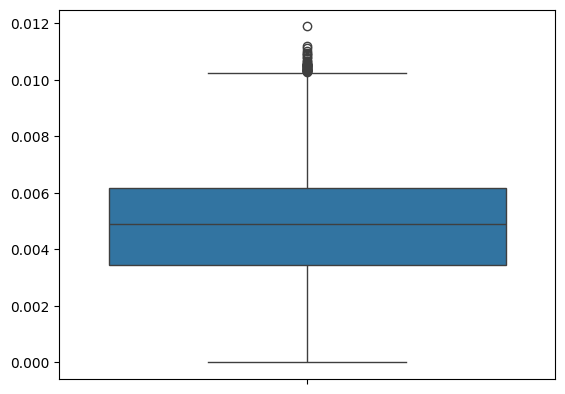

In [59]:
sns.boxplot(MEAN_TF_IDF_TRAIN);

<Axes: >

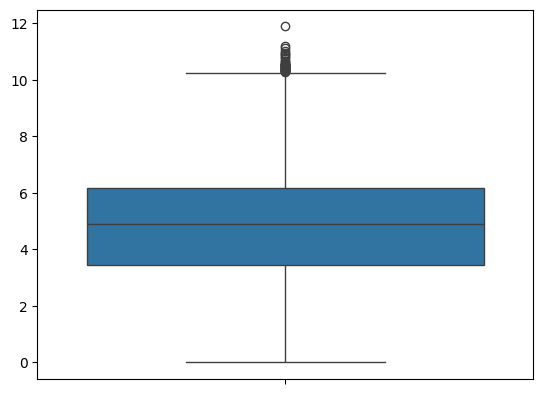

In [60]:
sns.boxplot(dense_tfidf_matrix_train.sum(1))

Нет смысла брать в качестве фичей как среднее так и сумму по TF-IDF векторам, так как распределения у них похожи, различаются только порядки.

Поэтому оставим фичу `mean_tf_idf`

In [61]:
X_train["mean_tf_idf"] = MEAN_TF_IDF_TRAIN
X_test["mean_tf_idf"] = MEAN_TF_IDF_TEST

In [62]:
X_train.head(2)

,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model,mean_tf_idf
83119,Актобе,механика,хэтчбек/лифтбек,передний привод,Нет,слева,черный,168923,1.6,газ-бензин,16,ВАЗ (Lada)_2114 (хэтчбек),0.002611
14123,Алматы,механика,фургон,задний привод,Да,слева,белый,201291,2.7,бензин,17,ГАЗ_3302 (ГАЗель Бизнес),0.003008


# Encoding

Посмотрим сколько уникальных значений в каждой фиче:

In [63]:
cat_features_to_encode = ["city", "transmission", "body", "drive", "cleared", "wheel", "color", "liters", "fuel", "brand_model"]

for cat_feat in cat_features_to_encode:
    print(f"Количество уникальных значений в колонке {cat_feat}: {pd.concat([X_train, X_test])[cat_feat].nunique()}")

Количество уникальных значений в колонке city: 310
Количество уникальных значений в колонке transmission: 7
Количество уникальных значений в колонке body: 15
Количество уникальных значений в колонке drive: 3
Количество уникальных значений в колонке cleared: 2
Количество уникальных значений в колонке wheel: 2
Количество уникальных значений в колонке color: 42
Количество уникальных значений в колонке liters: 152
Количество уникальных значений в колонке fuel: 6
Количество уникальных значений в колонке brand_model: 1556


Декодируем бинарные фичи

In [64]:
X_train["cleared"] = X_train["cleared"].apply(lambda x: 1 if x == "Да" else 0)
X_test["cleared"] = X_test["cleared"].apply(lambda x: 1 if x == "Да" else 0)

X_train["wheel"] = X_train["wheel"].apply(lambda x: 0 if x == "слева" else 1)
X_test["wheel"] = X_test["wheel"].apply(lambda x: 0 if x == "слева" else 1)

Видно, что колонки `city`, `liters` и `brand_model` большое количество уникальных значений, а также это довольно важные фичи, поэтому для я думаю будет идеально использовать Target Encoding 

`color`, `transmission`, `body`, `drive`, `fuel` декодирую при помощи OneHotEncoding

In [65]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

In [66]:
te_features = ["city", "liters", "brand_model"]
ohe_features = ["color", "transmission", "body", "drive", "fuel"]

In [67]:
for feature in te_features:
    encoder = TargetEncoder()
    X_train_enc[feature] = encoder.fit_transform(X_train[feature], y_train)
    X_test_enc[feature] = encoder.transform(X_test_enc[feature])

In [68]:
for feature in ohe_features:
    ohe = OneHotEncoder(drop="first", handle_unknown="ignore")
    train_encodings = ohe.fit_transform(X_train_enc[[feature]]).toarray()
    test_encodings = ohe.transform(X_test_enc[[feature]]).toarray()

    encoded_df_train = pd.DataFrame(train_encodings, columns=ohe.get_feature_names_out([feature]))
    encoded_df_train.index = X_train_enc.index

    encoded_df_test = pd.DataFrame(test_encodings, columns=ohe.get_feature_names_out([feature]))
    encoded_df_test.index = X_test_enc.index
    
    # Объединение с исходным DataFrame
    X_train_enc = pd.concat([X_train_enc, encoded_df_train], axis=1)
    X_test_enc = pd.concat([X_test_enc, encoded_df_test], axis=1)

    X_train_enc = X_train_enc.drop(feature, axis=1)
    X_test_enc = X_test_enc.drop(feature, axis=1)

/Users/fedor/Desktop/CVs/kept_case/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [69]:
X_train_enc.head(1)

,city,cleared,wheel,mileage,liters,age,brand_model,mean_tf_idf,color_бежевый металлик,color_белый,...,body_универсал,body_фургон,body_хэтчбек/лифтбек,drive_передний привод,drive_полный привод,fuel_газ,fuel_газ-бензин,fuel_гибрид,fuel_дизель,fuel_электричество
83119,2.501591e+06,0,0,168923,2.168719e+06,16,893840.886898,0.002611,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


# Metrics

В данной задаче у нас нет нужды использовать асимметричные метрики, так для нас ситуации недопрогноза и перепрогноза являются одинаково важными.

**MAE** покажет абсолютную ошибку, но она допускает большие ошибки в прогнозе, что для нас может быть критично

**MSE** в данной ситуации подойдет лучше, поскольку она штрафует модель за большие ошибки, возводя ошибку в квадрат. Отлично подходит для данной задачи. Также можно использовать **RMSE** - корень из MSE, чтобы интерпретировать ошибки в их изначальном порядке, а не возведенном в квадрат

Также здесь будет полезна **R-squared**, чтобы понимать, какая доля вариативности таргета объясняется моделью

In [70]:
def calculate_metrics(y_pred, y_true):
    print(f"MSE:  {round(mean_squared_error(y_pred=y_pred, y_true=y_true))}")
    print(f"RMSE: {round(root_mean_squared_error(y_pred=y_pred, y_true=y_true))}")
    print(f"MAE:  {round(mean_absolute_error(y_pred=y_pred, y_true=y_true))}")
    print(f"R^2   {round(r2_score(y_pred=y_pred, y_true=y_true), 2)}")
    print("-" * 80)

# Modeling

**Пойдем следующим путем:**
1) Отберем фичи для Lin Reg, путем обучения его с l1-нормой на нормализированных данных. Дальше обучим **baseline Lin Reg**, но вероятно он не сможет уловить хорошо зависимость данных
2) Обучим **RandomForest** на всех фичах, может хорошо отработать в данной задаче
3) Обучим град. бустинг на всех фичах, я буду использовать **CatBoost**. Должен отлично сработать

## Linear Reg

In [71]:
X_train_enc.head(1)

,city,cleared,wheel,mileage,liters,age,brand_model,mean_tf_idf,color_бежевый металлик,color_белый,...,body_универсал,body_фургон,body_хэтчбек/лифтбек,drive_передний привод,drive_полный привод,fuel_газ,fuel_газ-бензин,fuel_гибрид,fuel_дизель,fuel_электричество
83119,2.501591e+06,0,0,168923,2.168719e+06,16,893840.886898,0.002611,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [72]:
columns_to_scale = ["city", "mileage", "liters", "brand_model", "mean_tf_idf"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough' # не трогать остальные колонки
)

In [73]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=100, random_state=1)) #пробовал 0.01, 0.1, 1, 10, 100
])

In [74]:
pipe.fit(X_train_enc, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['city', 'mileage', 'liters',
                                                   'brand_model',
                                                   'mean_tf_idf'])])),
                ('lasso', Lasso(alpha=100, random_state=1))])

In [75]:
y_pred = pipe.predict(X_test_enc)

In [76]:
calculate_metrics(y_pred, y_test)

MSE:  1713918301058
RMSE: 1309167
MAE:  918512
R^2   0.73
--------------------------------------------------------------------------------


Возьмем это за *baseline*

In [77]:
pipe["lasso"].coef_

array([ 3.84436608e+04,  8.65934246e+00,  3.82639750e+05,  1.06919486e+06,
        2.09348589e+05,  7.52946742e+05, -5.97747142e+05, -1.01408051e+05,
       -3.71023319e+04,  7.58521554e+04,  2.48598166e+05,  5.30906500e+04,
        0.00000000e+00,  1.55339692e+05,  1.26821839e+05,  3.69574977e+05,
        3.35184507e+05,  1.12538016e+05,  9.16651857e+04, -1.31269352e+05,
       -3.21868699e+04, -1.61084605e+05,  0.00000000e+00, -6.16227617e+04,
       -8.16216470e+04, -4.06877397e+05, -2.59571552e+05,  1.59358312e+05,
        2.74025837e+05,  2.20916173e+05,  1.70573554e+05, -0.00000000e+00,
       -2.53516287e+05,  0.00000000e+00,  0.00000000e+00, -7.69698234e+04,
       -4.79605116e+04, -3.99912877e+04,  6.75469201e+04,  4.57923434e+04,
        6.25482869e+04,  0.00000000e+00, -2.27720471e+04,  1.93156971e+05,
        2.54264681e+05,  0.00000000e+00,  4.47643995e+04,  8.39464176e+04,
        2.10680225e+05, -0.00000000e+00,  0.00000000e+00,  5.30051682e+05,
       -4.97982046e+05, -

Не получилось занулить признаки. Модель часто ошибается

## RandomForest

In [78]:
forest = RandomForestRegressor(max_depth=3)

In [79]:
forest.fit(X_train_enc, y_train)

RandomForestRegressor(max_depth=3)

In [80]:
y_pred = forest.predict(X_test_enc)

In [81]:
calculate_metrics(y_pred=y_pred, y_true=y_test)

MSE:  2035354159072
RMSE: 1426658
MAE:  924950
R^2   0.68
--------------------------------------------------------------------------------


Подберем параметры для модели

In [82]:
param_distributions = {
    'n_estimators': np.arange(100, 501, 200),
    'max_depth': np.arange(5, 31, 10),
    'min_samples_split': np.arange(2, 11, 4),
    'min_samples_leaf': np.arange(1, 11, 4),
    'max_features': ["sqrt"]
}

forest = RandomForestRegressor(random_state=1)

random_search = RandomizedSearchCV(
    estimator=forest, 
    param_distributions=param_distributions,
    n_iter=10,
    cv=4,
    verbose=1, 
    random_state=1, 
    n_jobs=-1
)

random_search.fit(X_train_enc, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 5, 15, 25]),
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': array([1, 5, 9]),
                                        'min_samples_split': array([ 2,  6, 10]),
                                        'n_estimators': array([100, 300, 500])},
                   random_state=1, verbose=1)

In [83]:
random_search.best_estimator_

RandomForestRegressor(max_depth=15, max_features='sqrt', random_state=1)

In [84]:
print("TRAIN")
calculate_metrics(y_pred=random_search.best_estimator_.predict(X_train_enc), y_true=y_train)

print("TEST")
calculate_metrics(y_pred=random_search.best_estimator_.predict(X_test_enc), y_true=y_test)

TRAIN
MSE:  609467226405
RMSE: 780684
MAE:  506102
R^2   0.9
--------------------------------------------------------------------------------
TEST
MSE:  835658459215
RMSE: 914144
MAE:  571680
R^2   0.87
--------------------------------------------------------------------------------


Получили довольную неплохую модель с хорошим r^2 коэф и обощающей способностью.

Попробуем немного изменить параметры поиска

In [85]:
param_distributions = {
    'n_estimators': np.arange(100, 401, 100),  # Меньше деревьев
    'max_depth': np.arange(10, 26, 5),  # Меньшая максимальная глубина
    'min_samples_split': np.arange(2, 21, 2),  # Больше образцов для разделения узла
    'min_samples_leaf': np.arange(1, 21, 2),  # Больше образцов в листе узла
    'max_features': ["sqrt"]  # Меньше признаков для разделения
}

forest = RandomForestRegressor(random_state=1)

random_search_2 = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_distributions,
    n_iter=10,
    cv=4,
    verbose=1,
    random_state=1,
    n_jobs=-1
)

# Проводим поиск на тренировочных данных
random_search_2.fit(X_train_enc, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([10, 15, 20, 25]),
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'n_estimators': array([100, 200, 300, 400])},
                   random_state=1, verbose=1)

In [86]:
random_search_2.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=4, n_estimators=400, random_state=1)

In [87]:
print("TRAIN")
calculate_metrics(y_pred=random_search_2.best_estimator_.predict(X_train_enc), y_true=y_train)

print("TEST")
calculate_metrics(y_pred=random_search_2.best_estimator_.predict(X_test_enc), y_true=y_test)

TRAIN
MSE:  599561908829
RMSE: 774314
MAE:  484443
R^2   0.91
--------------------------------------------------------------------------------
TEST
MSE:  794046683120
RMSE: 891093
MAE:  546243
R^2   0.87
--------------------------------------------------------------------------------


Получили даже лучше модель.

Стоит еще поэксперементировать с подбором параметров

## CatBoost

Будем использовать catboost с autoencoder фичей.

Catboost классно реализован и хорошо работает с параметрами модели по умолчанию, поэтому пока что не буду его тюнить

In [88]:
X_train.head(1)

,city,transmission,body,drive,cleared,wheel,color,mileage,liters,fuel,age,brand_model,mean_tf_idf
83119,Актобе,механика,хэтчбек/лифтбек,передний привод,0,0,черный,168923,1.6,газ-бензин,16,ВАЗ (Lada)_2114 (хэтчбек),0.002611


In [89]:
catboost = CatBoostRegressor(random_state=1, 
                             cat_features=["city", "transmission", "body", "drive", "color", "liters", "fuel", "age", "brand_model"])

In [90]:
catboost.fit(X_train, y_train)

Learning rate set to 0.082126
0:	learn: 2382813.5610475	total: 87.3ms	remaining: 1m 27s
1:	learn: 2264553.9533926	total: 110ms	remaining: 55s
2:	learn: 2157124.1792831	total: 126ms	remaining: 41.7s
3:	learn: 2059592.9615733	total: 149ms	remaining: 37.1s
4:	learn: 1978571.2121154	total: 163ms	remaining: 32.5s
5:	learn: 1896189.1708470	total: 181ms	remaining: 29.9s
6:	learn: 1818398.6857165	total: 218ms	remaining: 31s
7:	learn: 1753240.6118406	total: 258ms	remaining: 32s
8:	learn: 1688916.6554045	total: 284ms	remaining: 31.2s
9:	learn: 1632267.3417025	total: 308ms	remaining: 30.5s
10:	learn: 1583537.3353226	total: 331ms	remaining: 29.8s
11:	learn: 1539735.5067768	total: 360ms	remaining: 29.6s
12:	learn: 1498066.3738030	total: 384ms	remaining: 29.2s
13:	learn: 1462166.0629473	total: 406ms	remaining: 28.6s
14:	learn: 1431790.1026881	total: 431ms	remaining: 28.3s
15:	learn: 1397804.6236593	total: 450ms	remaining: 27.7s
16:	learn: 1366090.0293526	total: 472ms	remaining: 27.3s
17:	learn: 1339

In [91]:
y_pred = catboost.predict(X_test)

In [92]:
print("TRAIN")
calculate_metrics(y_pred=catboost.predict(X_train), y_true=y_train)

print("TEST")
calculate_metrics(y_pred=catboost.predict(X_test), y_true=y_test)


TRAIN
MSE:  489159901589
RMSE: 699400
MAE:  430086
R^2   0.92
--------------------------------------------------------------------------------
TEST
MSE:  584613482682
RMSE: 764600
MAE:  459023
R^2   0.91
--------------------------------------------------------------------------------


Catboost даже из коробки сработал лучше, чем предыдущие модели, показав хорошую обобщающую способность и качество модели.

На тесте **MAE=92 500 руб**. Это довольно неплохо и означает, что мы можем довольно точно оценить стоимость автомобиля

In [93]:
feature_imprts = pd.DataFrame({"feature": catboost.feature_names_, "imprt": catboost.feature_importances_}) \
    .sort_values("imprt", ascending=False)
feature_imprts.head(2)

,feature,imprt
10,age,24.995080
11,brand_model,17.004251


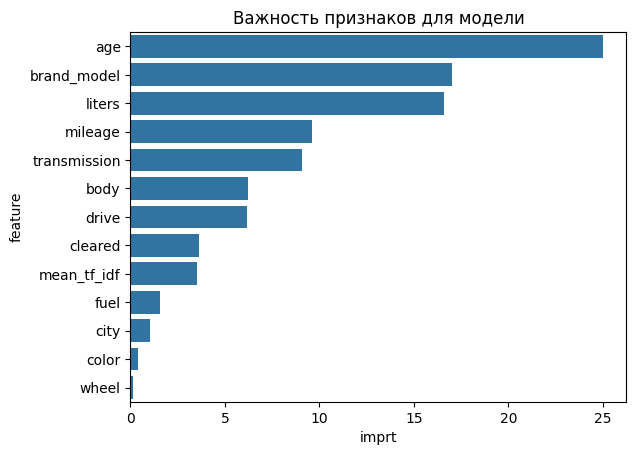

In [94]:
sns.barplot(data=feature_imprts, x="imprt", y="feature")

plt.title("Важность признаков для модели")

plt.show()

`age`, `liters`, `brand_model` и `mileage` оказались наиболее важными признаками для модели, что интуитивно логично. 

In [95]:
catboost.save_model("../src/artifacts/catboost_model")